## Udacity Self-Driving Car Nanodegree

## Project #4: Advanced Lane Finding

#### Samuel Rustan
February Cohort


### Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

#### 1. Camera Calibration (Using Chessboard reference images)

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

print('Camera Calibration Complete')

Camera Calibration Complete


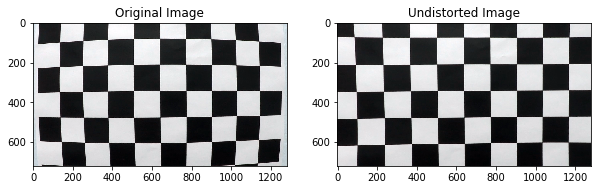

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb"))

# Visualize Distortion Correction

plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(122)
plt.imshow(dst)
plt.title('Undistorted Image')


#### 2. Distortion Correction

In [4]:
def undistort(img):
    """Read in image.
       Requires pickled calibration file
       Return undistored image
    """
    calibration = pickle.load( open("calibration.p", "rb") )
    mtx = calibration['mtx']
    dist = calibration['dist']
    undist_img = cv2.undistort(img,mtx,dist,None,mtx)
    return undist_img

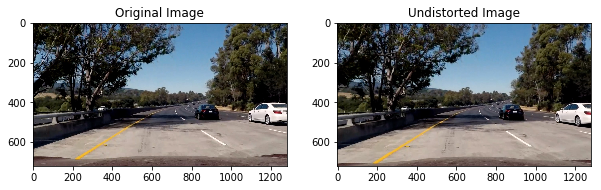

In [5]:
test_img = cv2.imread('./test_images/test5.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_undistort = undistort(test_img)

# Visualize undistortion

plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(test_img)
plt.title('Original Image')

plt.subplot(122)
plt.imshow(test_img_undistort)
plt.title('Undistorted Image')

Note the car hood and the white car for appreciable effects.

#### 3. Image Thresholding with Binary Output

In [6]:
def dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary 
    return binary_output

def hsv_thresh(img, ch, thresh=(127, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2h) Apply a threshold to the H channel
    if ch == 'h' : 
        binary_output = np.zeros_like(hls[:,:,0])
        binary_output[(hls[:,:,0] > thresh[0]) & (hls[:,:,0] <= thresh[1])] = 1
    # 2) Apply a threshold to the S channel
    if ch == 's' :
        binary_output = np.zeros_like(hls[:,:,1])
        binary_output[(hls[:,:,1] > thresh[0]) & (hls[:,:,1] <= thresh[1])] = 1
    # 2s) Apply a threshold to the V channel
    if ch == 'v' : 
        binary_output = np.zeros_like(hls[:,:,2])
        binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def hls_thresh(img, thresh=(127, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    if ch == 'h' : 
        binary_output = np.zeros_like(hls[:,:,2])
        binary_output[(hls[:,:,0] > thresh[0]) & (hls[:,:,0] <= thresh[1])] = 1
    if ch == 'l' : 
        binary_output = np.zeros_like(hls[:,:,2])
        binary_output[(hls[:,:,1] > thresh[0]) & (hls[:,:,1] <= thresh[1])] = 1
    if ch == 's'
        binary_output = np.zeros_like(hls[:,:,2])
        binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output


SyntaxError: invalid syntax (<ipython-input-6-4f9eb231414b>, line 81)

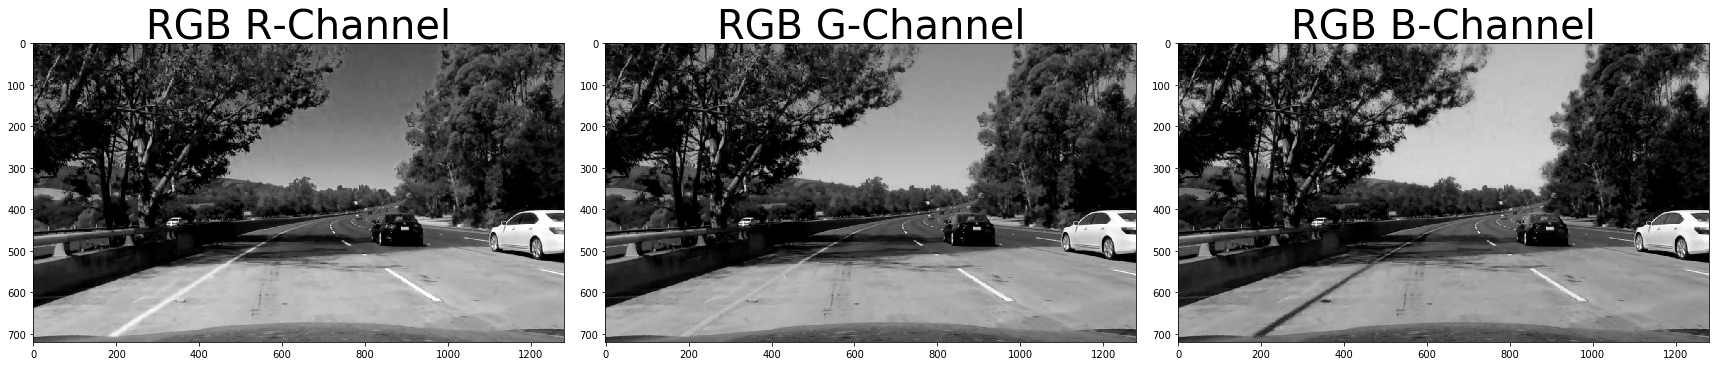

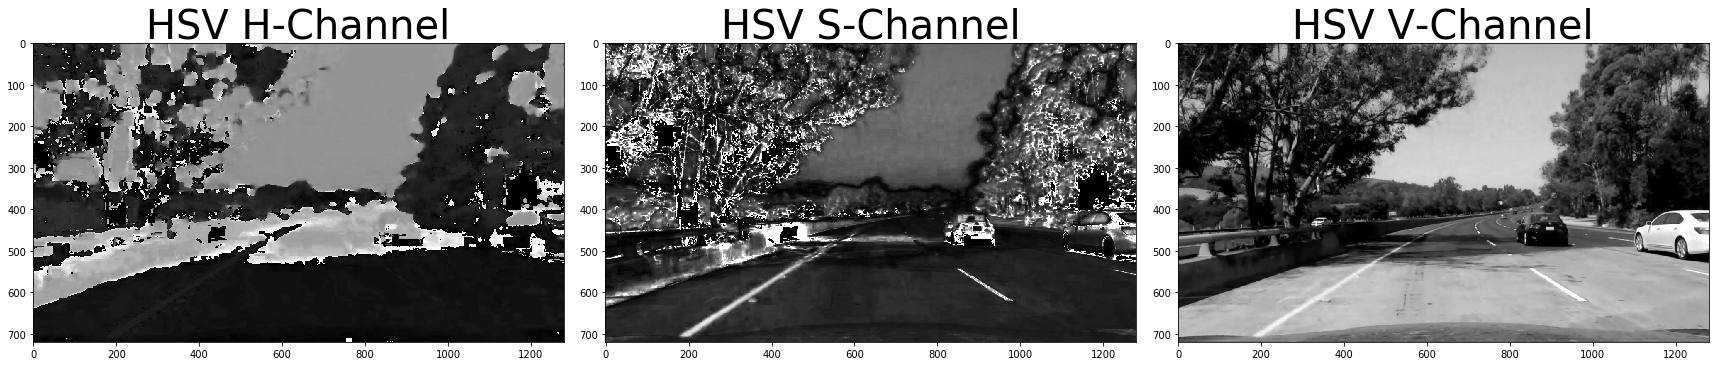

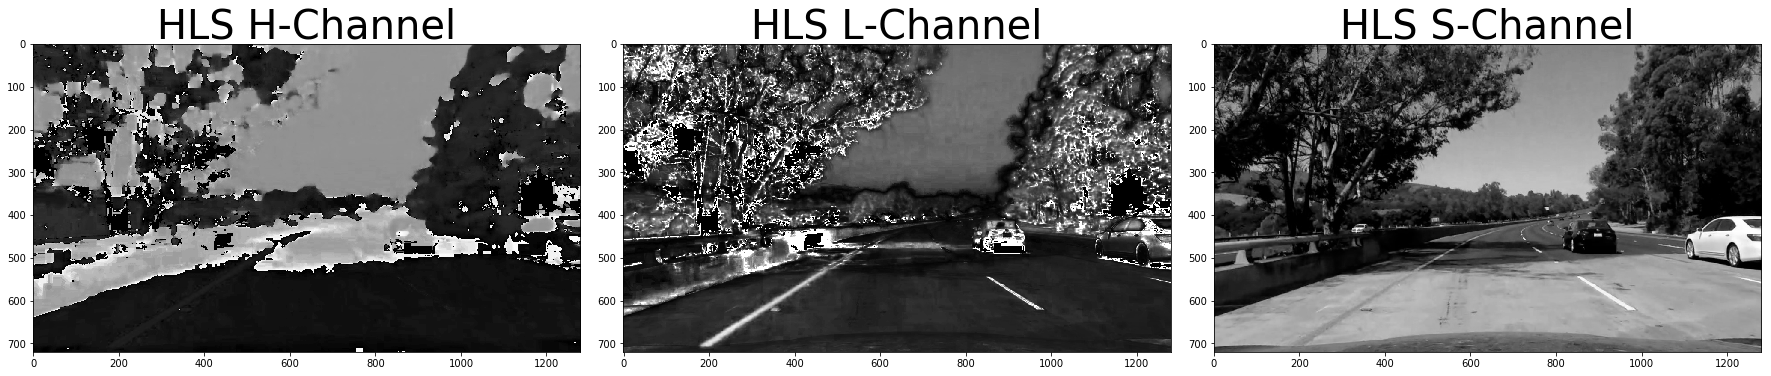

In [7]:
# Set the color channels
# RGB Channels
test_img_R = test_img_undistort[:,:,0]
test_img_G = test_img_undistort[:,:,1]
test_img_B = test_img_undistort[:,:,2]

# HSV Channels
test_img_HSV = cv2.cvtColor(test_img_undistort, cv2.COLOR_RGB2HSV)
test_img_H1 = test_img_HSV[:,:,0]
test_img_S = test_img_HSV[:,:,1]
test_img_V = test_img_HSV[:,:,2]

# HLS Channels
test_img_HLS = cv2.cvtColor(test_img_undistort, cv2.COLOR_RGB2HLS)
test_img_H2 = test_img_HLS[:,:,0]
test_img_L = test_img_HLS[:,:,1]
#test_img_S = hls_s_thresh(test_img_undistort[:,:,2])
test_img_S = test_img_HLS[:,:,2]

# RGB Channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img_R, cmap='gray')
ax1.set_title('RGB R-Channel', fontsize=40)
ax2.imshow(test_img_G, cmap='gray')
ax2.set_title('RGB G-Channel', fontsize=40)
ax3.imshow(test_img_B, cmap='gray')
ax3.set_title('RGB B-Channel', fontsize=40)

# HSV Channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img_H1, cmap='gray')
ax1.set_title('HSV H-Channel', fontsize=40)
ax2.imshow(test_img_S, cmap='gray')
ax2.set_title('HSV S-Channel', fontsize=40)
ax3.imshow(test_img_V, cmap='gray')
ax3.set_title('HSV V-Channel', fontsize=40)

# HSV Channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img_H2, cmap='gray')
ax1.set_title('HLS H-Channel', fontsize=40)
ax2.imshow(test_img_S, cmap='gray')
ax2.set_title('HLS L-Channel', fontsize=40)
ax3.imshow(test_img_L, cmap='gray')
ax3.set_title('HLS S-Channel', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

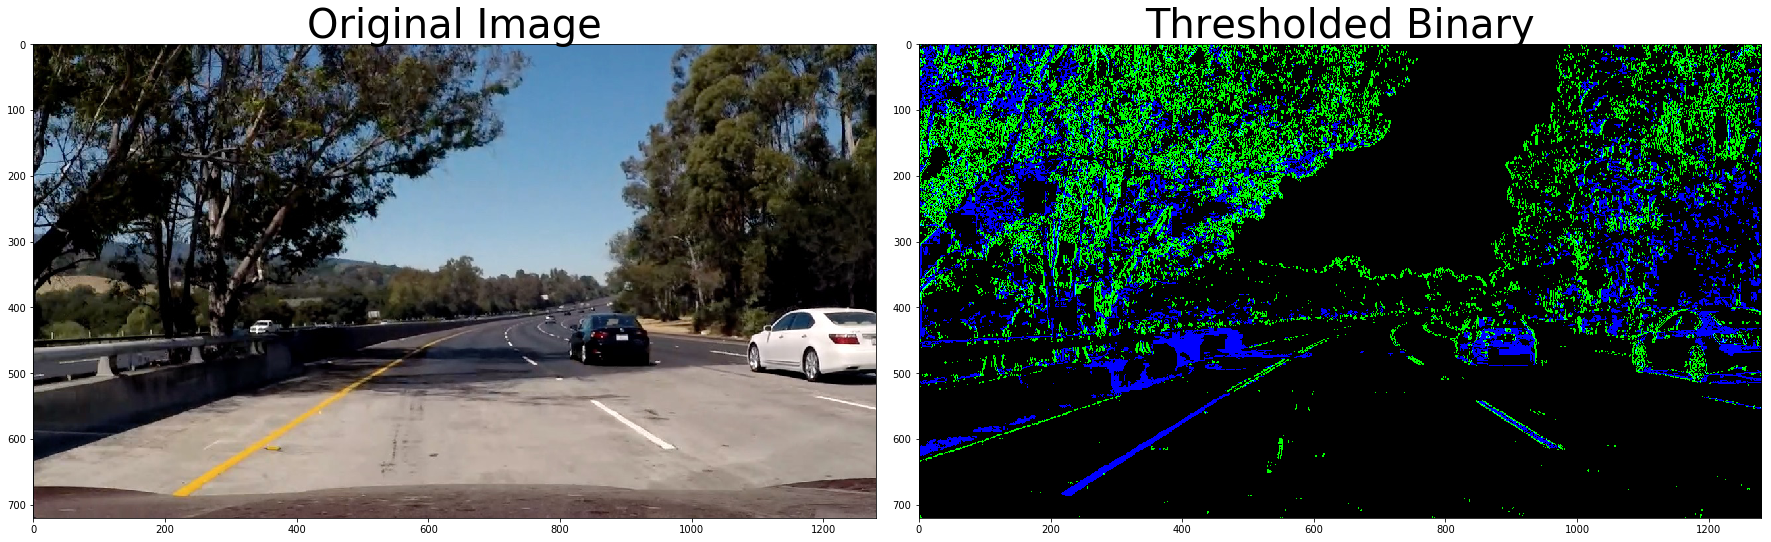

In [8]:
def thresh_color(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
result = thresh_color(test_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Thresholded Binary', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 4. Perspective Transform

In [9]:
def perspect_tf(img, src, dst):
    # get dims h,w for warpPerspective()
    h,w = img.shape[:2]
    # get the transform matrix, M
    M = cv2.getPerspectiveTransform(src, dst)
    # get the inverse transform matrix, Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv


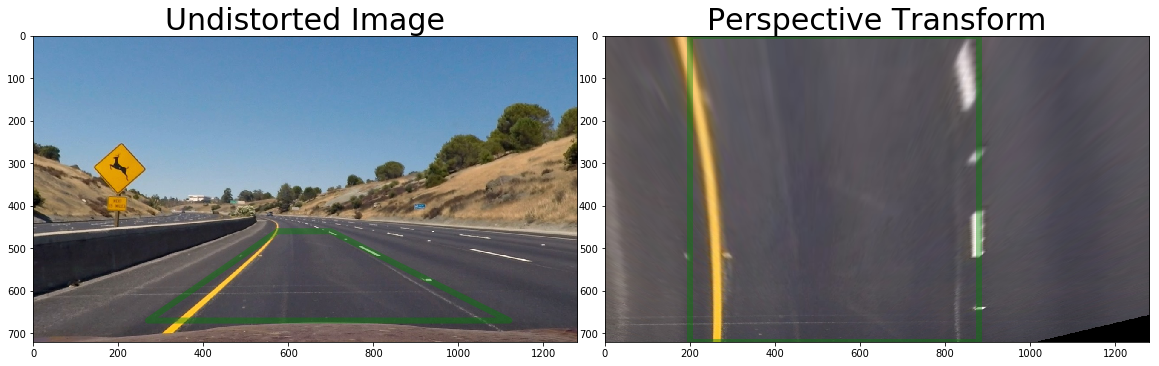

In [10]:
test_img = cv2.imread('./test_images/test2.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_undistort = undistort(test_img)
#cv2.undistort(test_img, mtx, dist, None, mtx)
# image dimenstions
h,w = test_img_undistort.shape[:2]

src = np.float32([(575,460),
                  (700,460), 
                  (270,670), 
                  (1120,670)])
dst = np.float32([(200,0),
                  (w-400,0),
                  (200,h),
                  (w-400,h)])

test_img_unwarp, M, Minv = perspect_tf(test_img_undistort, src, dst)

# Visualize unwarp including the src area
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='green', alpha=0.4, linewidth=6, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(test_img_unwarp)
x2 = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
y2 = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax2.plot(x2, y2, color='green', alpha=0.4, linewidth=6, solid_capstyle='round', zorder=2)
ax2.set_ylim([h,0])
ax2.set_xlim([0,w])
ax2.set_title('Perspective Transform', fontsize=30)


Binary Thresholding on Unwarped Image

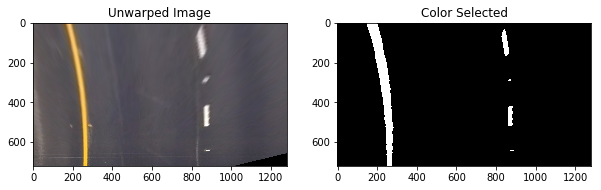

In [11]:
#def color_select(img, src, dst):
def color_select(img):
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #img, M, Minv = unwarp(img, src, dst)
    # For yellow
    yellow = cv2.inRange(HSV, (10, 100, 100), (50, 255, 255))
    
    # For white
    sensitivity_1 = 68
    white_1 = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))
    sensitivity_2 = 60
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    white_2 = cv2.inRange(HLS, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    white_3 = cv2.inRange(HLS, (200,200,200), (255,255,255))

    combined = yellow | white_1 | white_2 | white_3
    
    return combined


#combined, Minv = color_select(test_img_unwarp, src, dst)
combined = color_select(test_img_unwarp)
plt.figure(figsize=(10,40))

plt.subplot(121)
plt.imshow(test_img_unwarp, cmap='gray')
plt.title("Unwarped Image")

plt.subplot(122)
plt.imshow(combined, cmap='gray')
plt.title("Color Selected")

#bit_layer = your_bit_layer | yellow | white | white_2 | white_3

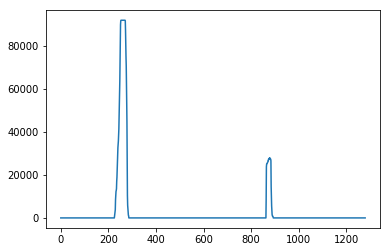

In [12]:
binary_warped = combined

histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

plt.plot(histogram)


#### 5. Detect Lane Lines

In [13]:
# Sliding Windows

def lane_finder(img, binary_warped, Minv):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) != 0: 
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

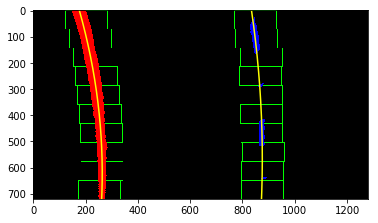

In [15]:
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = lane_finder(test_img, combined, Minv)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')



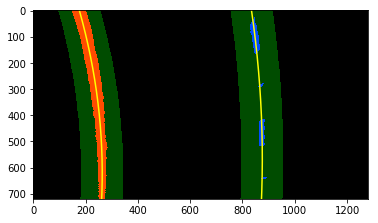

In [16]:
# Redraw lanes
nonzero = combined.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 80
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
if len(leftx) != 0: 
    left_fit = np.polyfit(lefty, leftx, 2)
if len(rightx) != 0:
    right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Visualize result
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot Result
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

#### Determine Radius of Curvature

In [17]:
# Radius of Curvature
# Define conversions in x and y from pixels space to meters
ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
x_mid = 650
y_eval = 720/2
# Fit new polynomials to x,y in world space
if len(leftx) != 0 and len(rightx) != 0:
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

curvature = (left_curverad + right_curverad)/2

print('\nRadius of Curvature: ' + str(curvature) + ' m')



Radius of Curvature: 1000.07666791 m


#### Draw Lane onto original image, include Radius info

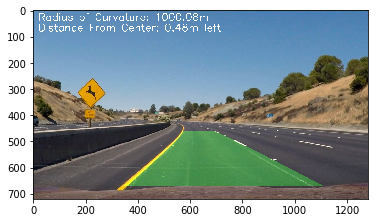

In [18]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(test_img, 1, newwarp, 0.3, 0)

#######
cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1.3,(255,255,255),2)

x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
position_from_center = ((x_left_pix + x_right_pix)/2 - x_mid) * xm_per_pix
if position_from_center < 0:
    text = 'left'
else:
    text = 'right'
cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1.3,(255,255,255),2)


plt.imshow(result)

In [19]:
def lane_finder(img, binary_warped, Minv):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    #if len(leftx) != 0: 
    #    left_fit = np.polyfit(lefty, leftx, 2)
    #if len(rightx) != 0:
    #    right_fit = np.polyfit(righty, rightx, 2)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Radius of Curvature
    y_eval = np.max(ploty)/2
    ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Average the left and right curvature
    radii = (left_curverad + right_curverad)/2

    # Position from Center
    center_pos = binary_warped.shape[1]/2
    center_offset = (abs(center_pos - (leftx_base + rightx_base)/2))*xm_per_pix

    # Draw the lane onto the warped blank image
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # And recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # Add stat info as text displayed in upper left of video
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of Curvature: %.2fm' % radii,(20,40), font, 1.3,(255,255,255),2)
    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix)/2 - x_mid) * xm_per_pix
    if position_from_center < 0:
        side = 'left'
    else:
        side = 'right'
    position_from_center = np.absolute(position_from_center)
    cv2.putText(result,'Distance From Center: %.2fm %s' % (position_from_center, side),(20,80), font, 1.3,(255,255,255),2)

    return result

In [20]:
def process_image(image):
    undist = undistort(image)
    proc = color_select(undist)
    tf, M, Minv = perspect_tf(proc, src, dst)
    result = lane_finder(image, tf, Minv)
    return result

In [21]:
output_name = "sr_project_video_annotated.mp4"
input_file = VideoFileClip("project_video.mp4")
output_clip = input_file.fl_image(process_image)
output_clip.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video sr_project_video_annotated.mp4
[MoviePy] Writing video sr_project_video_annotated.mp4


100%|█████████▉| 1260/1261 [02:41<00:00,  8.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sr_project_video_annotated.mp4 



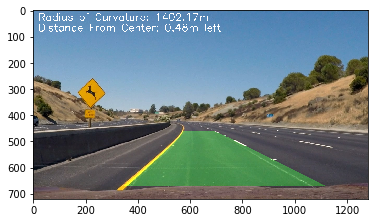

In [22]:
plt.imshow(process_image(test_img))